# Multiclass LDA for IRIS dataset

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import pi

# from utils import get_accuracy, get_prediction, plot_decision_boundary, generate_gifs
# from utils import plot_2D_input_datapoints, signum, multi_class_signum, normalize

### Importing the dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)

# dataset.Class

### Data preprocessing

Once dataset is loaded into a pandas data frame object, the first step is to divide dataset into features and corresponding labels and then divide the resultant dataset into training and test sets. The following code divides data into labels and feature set:

In [3]:
X = dataset.iloc[:, 0:4].values
# X = dataset.iloc[:, 0:2].values
y = dataset.iloc[:, 4].values

The above script assigns the first four columns of the dataset i.e. the feature set to X variable while the values in the fifth column (labels) are assigned to the y variable.

The following code divides data into training and test sets:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# print(y_test)

#### Feature Scaling

We will now perform feature scaling as part of data preprocessing too. For this task, we will be using scikit learn `StandardScalar`.

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test.shape

(30, 4)

## Write your code below

Write you code below to LDA on the IRIS dataset and compute the overall accuracy of the classifier.

In [6]:
### WRITE YOUR CODE HERE ####

# label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}
# print(label_dict)

# Calculating covariance of an input matrix
def calc_cov_matrix(X_input):
    n_samples = np.shape(X_input)[0]
    cov_matrix = np.array((1 / (n_samples-1)) * (X_input - X_input.mean(axis=0)).T.dot(X_input - X_input.mean(axis=0)))

    return cov_matrix

# Training the multiclass LDA model
def train(X_train, y_train):
    class_X0 = X_train[np.argwhere(y_train == 'Iris-setosa')[:, 0]]      #CLASS1
    class_X1 = X_train[np.argwhere(y_train == 'Iris-versicolor')[:, 0]]  #CLASS2
    class_X2 = X_train[np.argwhere(y_train == 'Iris-virginica')[:, 0]]   #CLASS3
    
    #Obtaining mean of 3 classes
    class_X0_mean = class_X0.mean(0)  
    class_X1_mean = class_X1.mean(0)
    class_X2_mean = class_X2.mean(0)
    
    #Obtaining mean difference between 3 classes
    class_mean_diff1 = class_X1_mean - class_X0_mean
    class_mean_diff2 = class_X2_mean - class_X0_mean
    class_mean_diff3 = class_X2_mean - class_X1_mean
    
    #Reshaping class mean differences
    class_mean_diff1 = class_mean_diff1.reshape((-1, 1))
    class_mean_diff2 = class_mean_diff2.reshape((-1, 1))
    class_mean_diff3 = class_mean_diff3.reshape((-1, 1))
    
    #Obtaining between scatter matrix Sb
    SB1 = np.dot(class_mean_diff1, class_mean_diff1.T)
    SB2 = np.dot(class_mean_diff2, class_mean_diff2.T)
    SB3 = np.dot(class_mean_diff3, class_mean_diff3.T)
    SB = SB1 + SB2 + SB3
#     print(SB.shape)

    #Obtaining covariance matrices and eventually within scatter matrix Sw
    cov_mat_class_X0 = calc_cov_matrix(class_X0)
    cov_mat_class_X1 = calc_cov_matrix(class_X1)
    cov_mat_class_X2 = calc_cov_matrix(class_X2)
    SW = cov_mat_class_X0 + cov_mat_class_X1 + cov_mat_class_X2 
    
    #Getting eigenvalues and eigenvectors for (Sw-1)Sb
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(SW).dot(SB))

    #Getting the 2 largest eigenvalues and their corresponding eigenvectors 
    eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    W = np.real(np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1))))

    # Getting the eigenvector with the maximum eigenvalue.
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx][:1]
    weights = np.atleast_2d(eigvecs[:, idx])[:, :1]    
    
    return weights, W, SB, SW

In [7]:
#Training the training data

w1, W, SB, SW= train(X_train, y_train)

## Obtaining overall accuracy

In [9]:
import copy
# Predict on test set
num_test_samples = np.shape(y_test)[0]
# print(num_test_samples)
y_test_predicted = np.dot(X_test, w1)

#Building three prediction classes 0, 1 and 2
y_test_predicted[y_test_predicted <= 0 ] = 0
for i in range(len(y_test_predicted)):
    if y_test_predicted[i]>0 and y_test_predicted[i] <=1:
        y_test_predicted[i] = 1
y_test_predicted[y_test_predicted > 1] = 2

#Converting class labels to 0,1 and 2 classes
y_test_copy = copy.deepcopy(y_test)
y_test_copy[y_test_copy == 'Iris-setosa'] = 0
y_test_copy[y_test_copy == 'Iris-versicolor'] = 1
y_test_copy[y_test_copy == 'Iris-virginica'] = 2

y_test_predicted = y_test_predicted.reshape((-1, 1))
y_test_copy = y_test_copy.reshape((-1, 1))


# Getting misclassfied points on test set
miscls_test_points = np.unique(np.argwhere(y_test_predicted != y_test_copy)[:, 0])
# print(len(miscls_test_points))
accuracy = 1-(len(miscls_test_points)/num_test_samples)
print("Accuracy of the Multiclass LDA is : ", accuracy*100)
# y_test

Accuracy of the Multiclass LDA is :  96.66666666666667


#### Accuracy is 96.7%

## Plotting the training set onto the new LD1 and LD2 discriminants, and plotting the decision boundaries

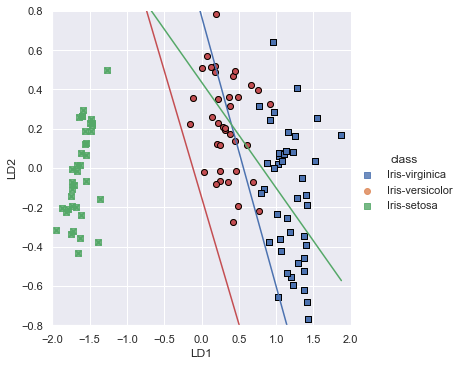

In [85]:
X_train_lda = X_train.dot(W)
# print(X_train_lda.shape)

data=pd.DataFrame(X_train_lda)
data['class']=y_train
data.columns=["LD1","LD2","class"]


markers = ['s', 'o','s']
sns.lmplot(x="LD1", y="LD2", data=data, markers=markers,fit_reg=False, hue='class', legend=True)
# Plot the hyperplanes
for l,c,m in zip(np.array(['Iris-virginica', 'Iris-setosa','Iris-versicolor']),['b','g','r'],['s','x','o']):
    plt.scatter(X_train_lda[y_train==l,0],
                X_train_lda[y_train==l,1],
                c=c, marker=m, label=l,edgecolors='black')

x1 = np.array([np.min(X_train_lda[:,0], axis=0), np.max(X_train_lda[:,0], axis=0)])

for i, c in enumerate(['b','g','r']):
    b, w1, w2 = 0.1, W[i][0], W[i][1]
    y1 = -(b+x1*w1)/w2    
    plt.plot(x1,y1,c=c)
    plt.xlim(-2, 2)
    plt.ylim(-0.8, 0.8)

plt.show()
# np.unique(y_train)

### The blue line seperates the iris-virginica and iris-versicolor class
### The green line seperates the iris-virginica and iris-setosa class
### The red line seperates the iris-versicolor and iris-setosa class

## Plotting the testing set onto the new LD1 and LD2 discriminants

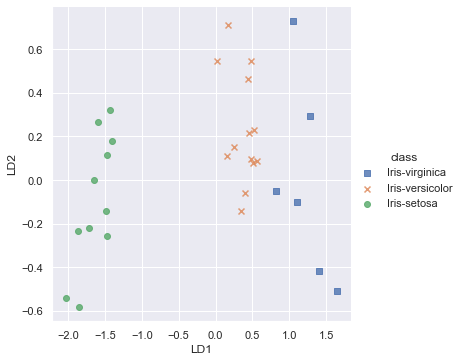

In [82]:
X_test_lda = X_test.dot(W)
# print(X_train_lda.shape)

data=pd.DataFrame(X_test_lda)
data['class']=y_test
data.columns=["LD1","LD2","class"]


markers = ['s', 'x','o']
sns.lmplot(x="LD1", y="LD2", data=data, markers=markers,fit_reg=False, hue='class', legend=True)

plt.show()
# y_test

## Plotting the decision boundary on the training set using sklearn inbuilt LDA(for comparision)

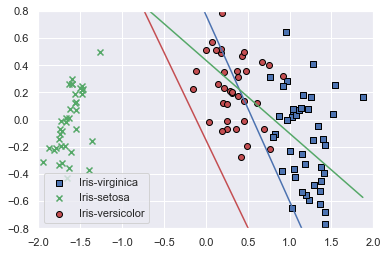

In [89]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(13)

# Generate 3 linearly separable dataset of 2 features
# X = [[0,0]]*25+[[0,10]]*25+[[10,10]]*25
# X = np.array(list(map(lambda x: list(map(lambda y: np.random.randn()+y, x)), X)))
# y = np.array([0]*25+[1]*25+[2]*25)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_object = lda.fit(X_train_lda, y_train)

# Plot the hyperplanes
for l,c,m in zip(np.array(['Iris-virginica', 'Iris-setosa','Iris-versicolor']),['b','g','r'],['s','x','o']):
    plt.scatter(X_train_lda[y_train==l,0],
                X_train_lda[y_train==l,1],
                c=c, marker=m, label=l,edgecolors='black')
    plt.legend(('Iris-virginica', 'Iris-setosa','Iris-versicolor'), loc = 'best')

x1 = np.array([np.min(X_train_lda[:,0], axis=0), np.max(X_train_lda[:,0], axis=0)])

for i, c in enumerate(['b','g','r']):
    b, w1, w2 = 0.1, W[i][0], W[i][1]
    y1 = -(b+x1*w1)/w2    
    plt.plot(x1,y1,c=c)
    plt.xlim(-2, 2)
    plt.ylim(-0.8, 0.8)

plt.show()
   

### The blue line seperates the iris-virginica and iris-versicolor class
### The green line seperates the iris-virginica and iris-setosa class
### The red line seperates the iris-versicolor and iris-setosa class